# Examining Raw Word Count and Naive Bayes

In this notebook, we explore the distribution of words in our comments and the potential of a naive bayes approach to subreddit classification.  jsons from the previous notebook are loaded and converted into a list of comments.

In [4]:
import pandas as pd
import json
import matplotlib.pyplot as plt

Many of the comments are written by bots; we assume they are not representative of the behavior under examination and toss these aside.  Lengths of the files are recorded to be used later in identifying their subreddit.

In [5]:
def concatCorp(files):
    corpii = []
    lengths = []
    for file in files:
        jsfile = json.load(open(file))
        corp = [data['body'].replace("'",'').replace("’", '')
                for data in jsfile['data'] 
                if 'i am a bot' not in data['body']
                and '[deleted]' not in data['body']
                and '[removed]' not in data['body']
               ]
        lengths.append(len(corp))
        corpii.extend(corp)
    return corpii, lengths

For now, we will inspect the first file, since it is the one currently available.  The code is written to conveniently extend to more files, though.

In [25]:
files = [f'./jsons/incels_comment_{i}.json' for i in range(1)]
files.extend([f'./jsons/foreveralone_comment_{i}.json' for i in range(1)])

In [26]:
all_coms, lengths = concatCorp(files)

In [27]:
lengths

[9348, 9552]

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

We retroactively add stop words here.  This list was updated for words that seemed to carry significant weight in distinguishing the two subreddits, but were not seen as relevant in heading towards the final application of this model.  Since we are training inspecting comments, we remove common English words in hopes of finding patterns in less common words when we look at those most important.

In [29]:
stops = set(ENGLISH_STOP_WORDS)
stops = stops.union({'www', 'reddit', 'deleted', 'https', 'com', 'http', 'incel', 'azavii', 'incels', 'imgur', 'youtube', 'gt'})

In [30]:
ct = CountVectorizer(
    max_df=0.8,
    min_df=20,
    token_pattern='[a-zA-Z][a-zA-Z]+',
    ngram_range=(1,2),
    stop_words=stops
)

In [31]:
covec = ct.fit_transform(all_coms)

In [32]:
countdf = pd.DataFrame(covec.todense(), columns = ct.get_feature_names())

We should note that here and in the next notebook, comments from r/incels is denoted as the positive 1 class.

In [33]:
countdf['Article'] = 1
countdf.loc[lengths[0]:, 'Article'] = 0

In [34]:
top_10_incels = countdf.query('Article==1').sum().sort_values(ascending=False).drop('Article', axis=0).head(10)

In [35]:
top_10_foreveralone = countdf.query('Article==0')[top_10_incels.index].sum().sort_values(ascending=False).head(10)

In [36]:
top_10_incels

just      1291
like      1248
women     1174
dont      1099
im         873
people     691
men        639
youre      621
fuck       558
chad       540
dtype: int64

We would like to compare the frequency of these words in the same number of comments from r/foreveralone.

In [37]:
top_10_foreveralone

just      2632
people    2395
im        2393
like      2276
dont      2196
youre      978
women      669
men        330
fuck       293
chad        64
dtype: int64

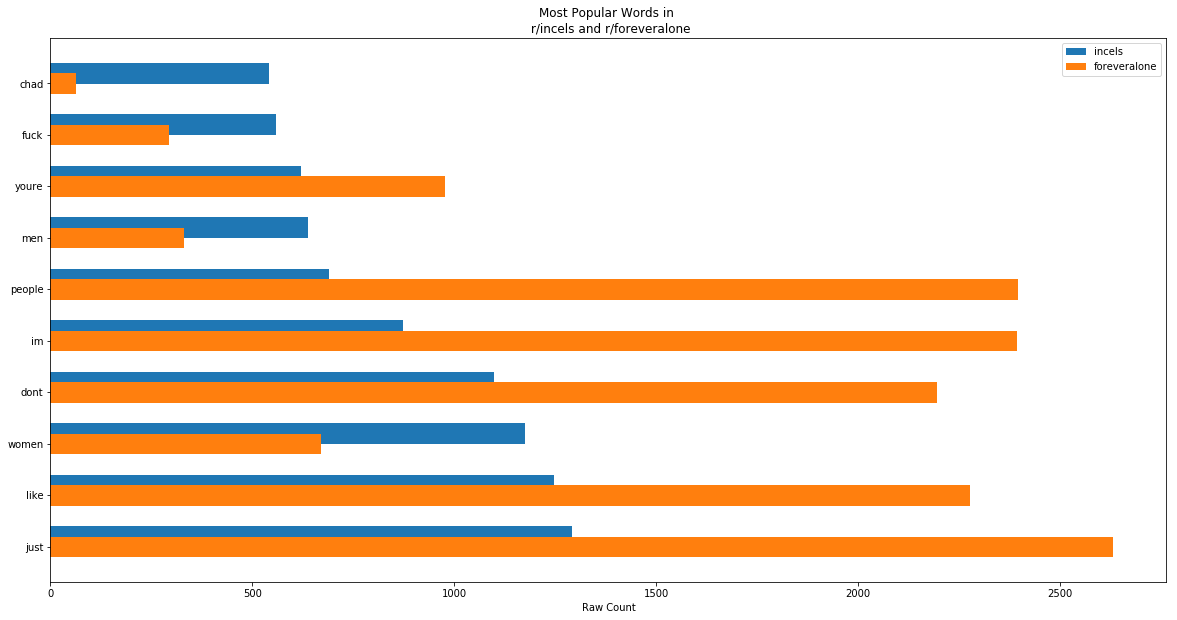

In [38]:
plt.figure(figsize=(20,10))
plt.barh(top_10_incels.index, top_10_incels, 0.4, align='edge')
plt.barh(top_10_foreveralone.index, top_10_foreveralone, 0.4, align='center')
plt.title('Most Popular Words in \n r/incels and r/foreveralone')
plt.legend(['incels', 'foreveralone'])
plt.xlabel('Raw Count');

We that despite the difference in total counts of the words, r/incels still manages to make mention of gender more than r/foreveralone.  We also see some a higher use of derogatory words, though chad is jargon more identified with incels.  Whether a more frequent appearance of the other words is meaningful without scaling is debatable.  The issue of scaling is considered in the next notebook, though in a hand-waving kind of way by just applying a TF-IDF transformation on the corpus.  We might consider the distribution of word-length of comments.

In [41]:
incels_length = countdf.query('Article==1').T.sum()
alone_length = countdf.query('Article==0').T.sum()

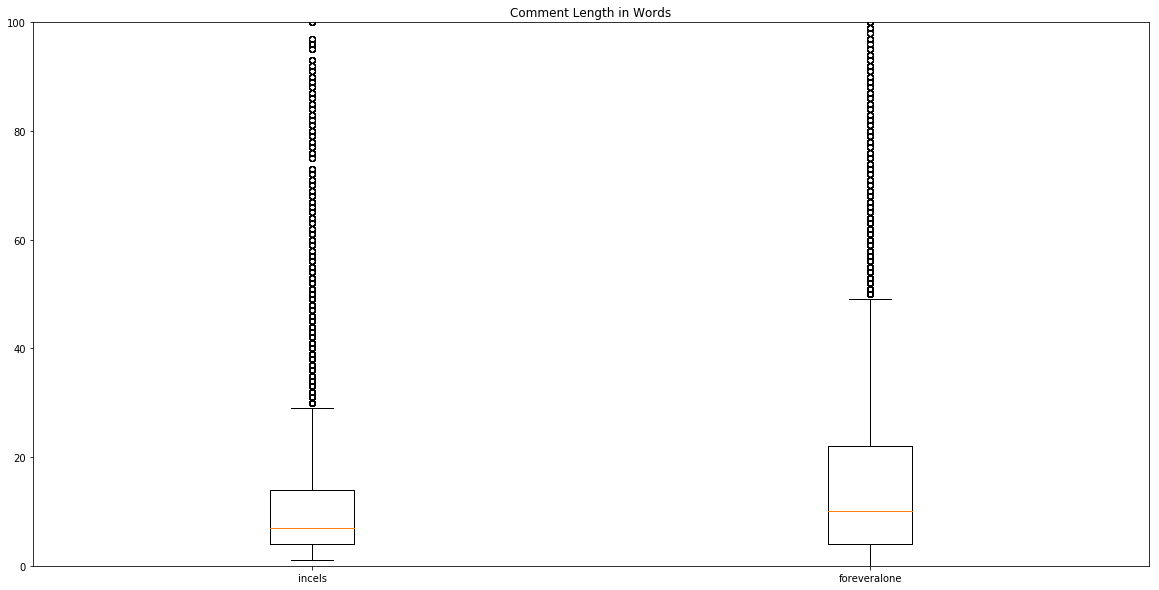

In [50]:
plt.figure(figsize=(20,10))
plt.boxplot([incels_length, alone_length], labels=['incels', 'foreveralone'])
plt.ylim((0,100))
plt.title('Comment Length in Words');

In [52]:
countdf.Article.value_counts()

1    47242
0    47242
Name: Article, dtype: int64

Considering that each subreddit has an equal amount of comments and the average comment in r/foreveralone is not near twice as long r/incels, we might consider the words appearing more frequently in the former to be telling of content.  Inspecting our bag-of-words gives us confidence that despite excluding some giveaway words that would immediately point to r/incels, we can detect a more basic distinction between r/foreveralone and r/incels which may later generalize to other subreddits (though this is getting way ahead of ourselves).  We move on to training a classifier.

## Training Naive Bayes

In the spirit of investigating differences through the frequency of words, we apply a Naive Bayes model to our word counts.  This model will predict classes simply based on the percent chance a single word appears in each document type; it captures no information on context, which intuitively seems necessary if we wish to generalize results beyond identifying these two specific subreddits.  We go ahead and inspect for accuracy.

In [39]:
from sklearn.model_selection import train_test_split
import numpy as np

In [40]:
np.random.seed(1)

In [41]:
xtrain, xtest, ytrain, ytest = train_test_split(countdf.iloc[:,:-1], countdf.iloc[:,-1])

In [42]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=3)
nb.fit(xtrain, ytrain)
nb.score(xtest, ytest)

0.7094179894179894

The results of this model are well above a random guess.  We try to see how well it generalizes to other forums:

In [46]:
def predictIncels(name, n_files):
    files = [f'./jsons/{name}_comment_{i}.json' for i in range(n_files)]
    pred_coms, lengths = concatCorp(files)
    xfinaltest = ct.transform(pred_coms)
    testdf = pd.DataFrame(xfinaltest.todense(), columns = ct.get_feature_names())
    return np.mean(nb.predict(testdf))

In [47]:
predictIncels('truecels', 1)

0.40902021772939345

In [49]:
predictIncels('changemyview', 1)

0.26486811754086853

In [50]:
predictIncels('mensrights', 1)

0.4107321965897693

Our model does just as well on the initial set of testing data as it does on our newly imported, more recent data.  It is not surprising that the model fails to generalize to other subreddits, but it is disappointing all the same.  There seems to be some success in recognizing r/changemyview, a subreddit that is moderated to include only civil argument, but we should keep in mind that this model only compares vocabulary; change my view simply does not use certain words at the same frequency as r/incels.  This result would be significant if we were convinced that we had removed all jargon, but for now, we move on to a model that would take care of word interactions by design - the Random Forest.

We will see later that these results are actually more accurate than what we would find in our next model.  However, this model was simply established to get an idea of the accuracy we should expect; the goal is to build a model that can account for behavior in a manner less obvious than whether a word is present, which may easily be circumvented.